In [49]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from xgboost import plot_importance
import matplotlib.pyplot as plt

from utils.query_snowflake import SnowflakeConnector

import mlflow

In [2]:
# Define local file path
data_path = r"C:\Users\User\PycharmProjects\pums\data\pums_raw.parquet"

# Check if file exists
if os.path.exists(data_path):
    print("Loading data from local Parquet file...")
    df = pd.read_parquet(data_path)
else:
    print("Parquet not found. Pulling from Snowflake...")
    sf = SnowflakeConnector()
    df = sf.query("SELECT * FROM public.pums_raw")
    sf.close()

    print("Saving to local Parquet...")
    os.makedirs(os.path.dirname(data_path), exist_ok=True)
    df.to_parquet(data_path, index=False)

Loading data from local Parquet file...


In [3]:
missing_ratio = df.isna().mean()
high_missing_ratio = df.loc[:, missing_ratio >= 0.95].columns.tolist()

In [4]:
# 1. Define groups
income_fields = ["FINCP", "HINCP",]
housing_fields = ["ELEP", "CONP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", 
                  "WATP", "GRNTP", "SMOCP", "TAXAMT", "CONP",]

# 2. Adjust to 2022 dollars
for field in income_fields:
    df[field] = df[field] * df["ADJINC"] / 1_000_000

for field in housing_fields:
    df[field] = df[field] * df["ADJHSG"] / 1_000_000

# Derived ratios
df["income_per_person"] = df["HINCP"] / (df["NP"].replace(0, np.nan))
df["income_per_room"] = df["HINCP"] / (df["RMSP"].replace(0, np.nan))
df["rent_to_income_ratio"] = df["RNTP"] / (df["HINCP"].replace(0, np.nan))

# Create binary target
df["FS"] = df["FS"].map({1: 1, 2: 0})

# 6. Count imputed features
alloc_cols = [
    col for col in df.columns
    if col.startswith("F") and col.endswith("P") and col not in ['FULFP', 'FULP', 'FINCP']
]

df["num_imputed_features"] = df[alloc_cols].eq(1).sum(axis=1)

df["age_group"] = pd.cut(
    df["HHLDRAGEP"],
    bins=[0, 30, 45, 60, 75, 120],
    labels=["young", "mid_young", "middle", "senior", "elderly"]
)

df = pd.get_dummies(df, columns=["age_group"], prefix="age")

df["age_x_income"] = df["HHLDRAGEP"] * df["HINCP"]

In [5]:
def map_cplt(val):
    if val in [1, 2]:
        return "Spouse_Household"
    elif val in [3, 4]:
        return "Partner_Household"
    else:
        return "Not_Couple"

df["CPLT_group"] = df["CPLT"].replace("b", np.nan).astype(float).apply(map_cplt)


def map_wkexrel(val):
    if val in [1, 2, 4, 5]:
        return "Both_Worked"
    elif val in [3, 6]:
        return "Householder_Worked_Only"
    elif val in [7, 8]:
        return "Spouse_Worked_Only"
    elif val == 9:
        return "Neither_Worked"
    elif val in [10, 13]:
        return "Householder_Alone_FT"
    elif val in [11, 14]:
        return "Householder_Alone_Part"
    elif val in [12, 15]:
        return "Householder_Alone_None"
    else:
        return "No_Family"


df["WKEXREL_group"] = df["WKEXREL"].replace("bb", np.nan).apply(map_wkexrel)

df = pd.get_dummies(df, columns=["CPLT_group", "WKEXREL_group"], dtype=int)

df.drop(columns=["CPLT", "WKEXREL"], inplace=True)

In [6]:
df = df[~df['FS'].isna()]
df = df.reset_index(drop=True)

In [48]:
df.FS.value_counts()

FS
0.0    60584
1.0     6838
Name: count, dtype: int64

## Start with few features

In [29]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
income_fields = ["FINCP", "HINCP"]
housing_fields = ["ELEP", "CONP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", "WATP", "GRNTP", "SMOCP", "TAXAMT",]
extra_fields = ["RMSP", "HHLDRAGEP", "WORKSTAT"]           
derived_fields = ["income_per_person", "income_per_room", "rent_to_income_ratio", "num_imputed_features", "age_x_income"]
ohe_fields = [col for col in df.columns if col.startswith(("CPLT_group_", "WKEXREL_group_"))]
features = income_fields + housing_fields + extra_fields + derived_fields + ohe_fields

X = df[features]
y = df["FS"]

print(len(features))

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))


34
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      6040
         1.0       0.64      0.33      0.44       703

    accuracy                           0.91      6743
   macro avg       0.78      0.65      0.69      6743
weighted avg       0.90      0.91      0.90      6743



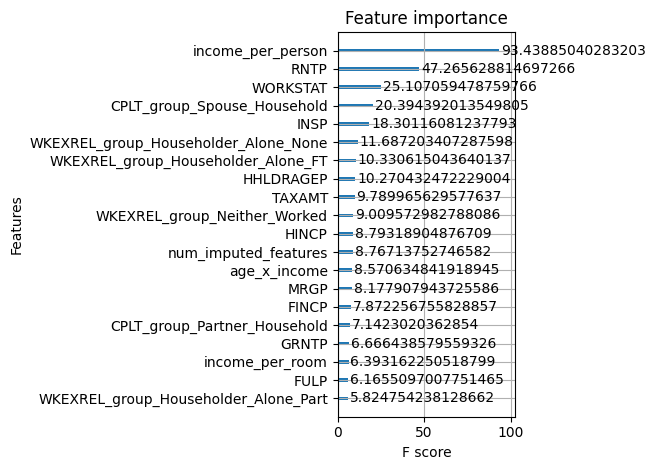

In [30]:
plot_importance(model, max_num_features=20, importance_type='gain')
plt.tight_layout()
plt.show()

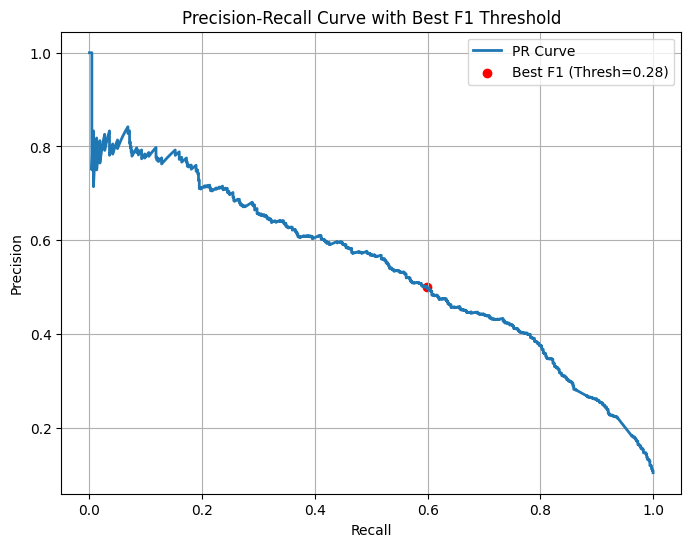

Best threshold: 0.28
F1 at best threshold: 0.546


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities (class 1 = received FS)
y_proba = model.predict_proba(X_test)[:, 1]

# Get precision-recall values for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the best F1 threshold and value
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")


In [38]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      6040
         1.0       0.54      0.65      0.59       703

    accuracy                           0.91      6743
   macro avg       0.75      0.79      0.77      6743
weighted avg       0.91      0.91      0.91      6743



## Expands to more features

In [39]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
housing_fields = [
    "VALP", "RNTM", "RNTP", "TEN", "GRNTP", "SMOCP", "SVAL", "MRGX", "MRGP",
    "YRBLT", "BDSP", "CONP", "INSP", "ACR", "FULP", "NR", "NRC",
]
income_fields = [
    "HINCP", "FINCP"
]

demographics_fields = [
    "NP", "NPF", "HHL", "HHT", "HHT2", "MULTG", "HHLDRAGEP", "PARTNER", "HHLDRHISP", "HHLDRRAC1P", "R18", "R60", "R65"
] + ['age_' + segment for segment in ["young", "mid_young", "middle", "senior", "elderly"]]

     
technology_access_fields = [
    "ACCESSINET", "COMPOTHX", "SMARTPHONE", "LAPTOP", "BROADBND", 
    "SMP", "TEL", "SATELLITE", "DIALUP",  
]

utility_cost_fields = [
    "ELEP", "GASP", "WATP", "OTHSVCEX", "TAXAMT"
]

geo_fields = ["PUMA10", "PUMA20", "RESMODE", "ST", "REGION"]

engineered_fields = [
    "income_per_person", "income_per_room", "rent_to_income_ratio", "num_imputed_features", "age_x_income"
]

ohe_fields = [col for col in df.columns if col.startswith(("CPLT_group_", "WKEXREL_group_"))]

allocation_flag_fields = [
    col for col in df.columns
    if col.startswith("F") and col.endswith("P") and col not in ['FULFP', 'FULP', 'FINCP']
]

extra_fields = ["RMSP", "WORKSTAT"]

features = (
    housing_fields + income_fields + demographics_fields + 
    technology_access_fields + utility_cost_fields + 
    geo_fields + engineered_fields + ohe_fields + allocation_flag_fields + extra_fields
)

X = df[features]
y = df["FS"]

print(len(features))

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))


129
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      6040
         1.0       0.69      0.36      0.48       703

    accuracy                           0.92      6743
   macro avg       0.81      0.67      0.72      6743
weighted avg       0.91      0.92      0.91      6743



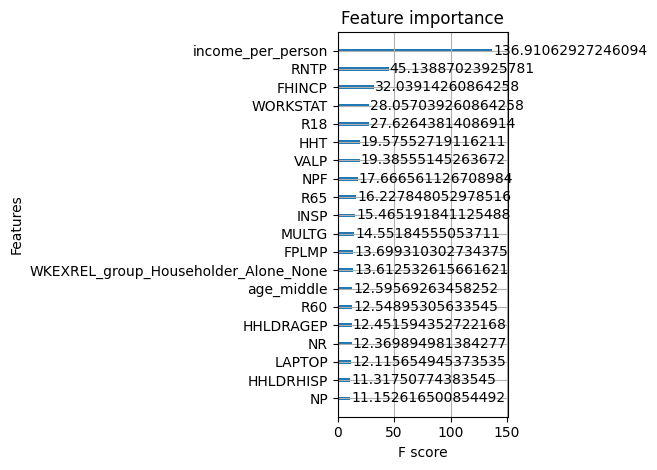

In [40]:
plot_importance(model, max_num_features=20, importance_type='gain')
plt.tight_layout()
plt.show()

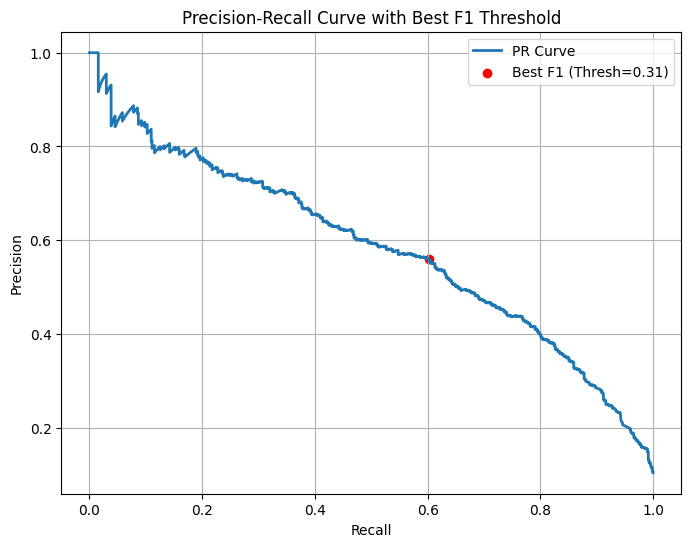

Best threshold: 0.31
F1 at best threshold: 0.581


In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities (class 1 = received FS)
y_proba = model.predict_proba(X_test)[:, 1]

# Get precision-recall values for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the best F1 threshold and value
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")


In [42]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      6040
         1.0       0.56      0.60      0.58       703

    accuracy                           0.91      6743
   macro avg       0.76      0.77      0.76      6743
weighted avg       0.91      0.91      0.91      6743



## All columns

In [43]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'WGTP', 'ADJINC', 'ADJHSG'] + ['WGTP' + str(i) for i in range(1, 81, 1)] + high_missing_ratio
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]

print(len(features))

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))


170
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      6040
         1.0       0.70      0.38      0.50       703

    accuracy                           0.92      6743
   macro avg       0.82      0.68      0.73      6743
weighted avg       0.91      0.92      0.91      6743



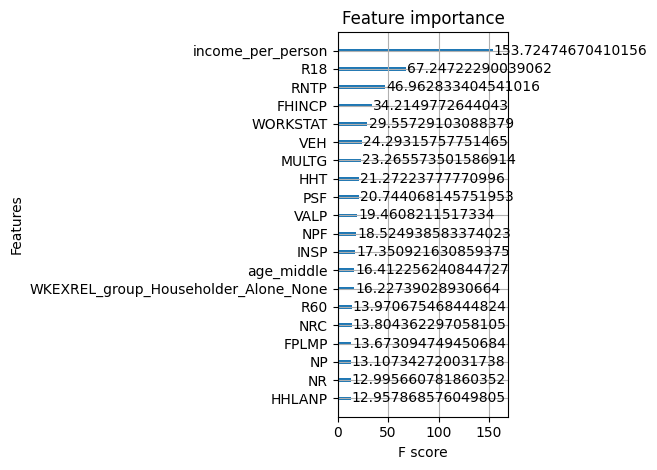

In [44]:
plot_importance(model, max_num_features=20, importance_type='gain')
plt.tight_layout()
plt.show()

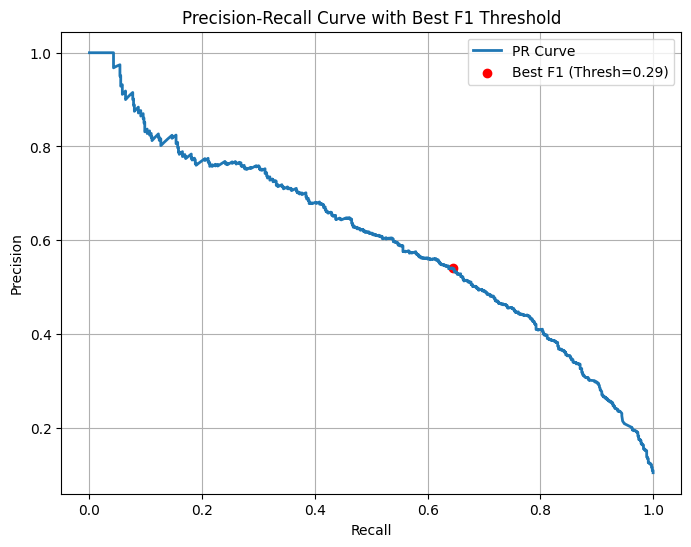

Best threshold: 0.29
F1 at best threshold: 0.588


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities (class 1 = received FS)
y_proba = model.predict_proba(X_test)[:, 1]

# Get precision-recall values for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the best F1 threshold and value
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")


In [47]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      6040
         1.0       0.54      0.65      0.59       703

    accuracy                           0.91      6743
   macro avg       0.75      0.79      0.77      6743
weighted avg       0.91      0.91      0.91      6743



## Imputer experiment

In [74]:
import miceforest as mf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


excluded = ['FS', 'RT', 'SERIALNO', 'WGTP', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)] + high_missing_ratio
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]

kernel = mf.ImputationKernel(df[features + ['FS']], random_state=42)
kernel.mice(1)
df_imputed = kernel.complete_data(0)

# Step 3: Split into features/target after imputation
X_imputed = df_imputed.drop(columns=["FS"])
y_imputed = df_imputed["FS"]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_imputed, test_size=0.1, random_state=42
)

# Step 5: Train and evaluate XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6040
           1       0.69      0.36      0.47       703

    accuracy                           0.92      6743
   macro avg       0.81      0.67      0.71      6743
weighted avg       0.90      0.92      0.90      6743



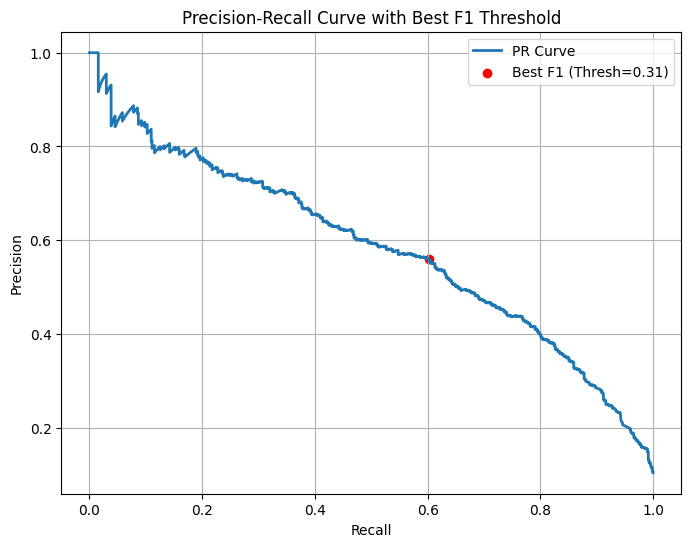

Best threshold: 0.31
F1 at best threshold: 0.581


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities (class 1 = received FS)
y_proba = model.predict_proba(X_test)[:, 1]

# Get precision-recall values for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the best F1 threshold and value
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")
